In [1]:
from functools import partial
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning_uq_box.datamodules import UCIRegressionDatamodule
from lightning_uq_box.datasets import UCIConcrete, UCIEnergy, UCIYacht
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import MVERegression, DeepEnsembleRegression
import scienceplots
import cmcrameri

import sys
sys.path.append("../../")
from uq import GaussianUQMeasure

: 

In [ ]:
root = "../../data/uci/"
experiment = "yacht"
ckpt_path = "../../results/robustness/checkpoints/"

In [ ]:
ensembles = 25
distortion = [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0]

In [ ]:
dm = UCIRegressionDatamodule(dataset_name = experiment, root = root, train_distortion=0, train_size = 0.9, batch_size=1000)
sample = next(iter(dm.train_dataloader()))
n_input = sample["input"].shape[-1]
trainer = Trainer()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
mlp = MLP(n_inputs = n_input, n_outputs = 2, activation_fn=nn.ReLU(), n_hidden = [256, 512, 1024])
model = MVERegression(
        mlp, optimizer=partial(torch.optim.Adam, lr=1e-2), burnin_epochs=20
    )

In [ ]:
base_ensemble = [{"base_model": model, "ckpt_path": f"{ckpt_path}/{experiment}/{experiment}_{x}.ckpt"} for x in range(ensembles)]
robustness_members = [{"base_model": model, "ckpt_path": f"{ckpt_path}/{experiment}/{experiment}_distorted_{x}.ckpt"} for x in distortion]

In [ ]:
# Base prediction
base_ensemble.append(robustness_members[1])
deep_ens_nll = DeepEnsembleRegression(base_ensemble)
input = next(iter(dm.train_dataloader()))
base_pred = deep_ens_nll.predict_step(input["input"])["samples"].detach()
log_sigma_2 = base_pred[:,1]
eps = torch.ones_like(log_sigma_2) * 1e-6
base_pred[:,1] = torch.sqrt(eps + np.exp(log_sigma_2))

In [ ]:
mu = base_pred[:,0,:]
sigma = base_pred[:,1,:]
sample_pred = torch.distributions.normal.Normal(mu, sigma).sample((40,)).swapaxes(0,1).flatten(start_dim = 1)
sample_pred.shape

torch.Size([276, 1040])

In [ ]:
sigma[:,-1].mean()

tensor(0.0111)

In [ ]:
# 1 - 0.24 5 - 1.9 0.1 - 0.01

In [ ]:
def median_heuristic_gamma(x: torch.Tensor) -> torch.Tensor:
    """
    Computes the gamma parameter for a Gaussian kernel using the median heuristic.
    
    Args:
        x (torch.Tensor): Input tensor of shape (B, M) where B is batch size and 
                          M are samples from a 1D standardized distribution.
                          
    Returns:
        torch.Tensor: Gamma values of shape (B,), one per batch.
    """
    B, M = x.shape
    
    # Expand dimensions for pairwise distance computation
    x1 = x.unsqueeze(2)  # (B, M, 1)
    x2 = x.unsqueeze(1)  # (B, 1, M)
    
    # Compute pairwise squared distances
    dists = (x1 - x2) ** 2  # (B, M, M)
    
    # Flatten upper triangular part (excluding diagonal)
    triu_indices = torch.triu_indices(M, M, offset=1)
    dists_flat = dists[:, triu_indices[0], triu_indices[1]]  # (B, M*(M-1)/2)
    
    # Median over pairwise distances
    median_sq = dists_flat.median()     
    # Gamma is sqrt of median squared distance
    gamma = torch.sqrt(median_sq)
    return gamma

# Example usage:
gamma = median_heuristic_gamma(sample_pred)
print("Estimated gamma:", gamma)

Estimated gamma: tensor(0.0036)


In [ ]:
# concrete: 0.0095, energy: 0.0033, yacht: 0.0036

# Load predictions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import cmcrameri
import sys
import numpy as np
sys.path.append("../../")

In [14]:
measures = ["log", "var", "crps", "kernel"]
experiment = "energy"
dist = [0.00,0.2,0.5,1.5,2.5,5.0]

In [15]:
df = pd.read_pickle(f"../../results/robustness/results/{experiment}_au.pkl")
df

0.0       0.1       0.2       0.3       0.4       0.5  \
5  log     0.005236  0.010386  0.024527   0.03641  0.042706  0.050726   
   var     0.054945  0.129817  0.473084  1.158961  1.709847  2.888462   
   crps    0.024955  0.053444  0.154083  0.283191  0.362986  0.495702   
   kernel  0.016427  0.028656  0.062667  0.084616  0.092458  0.101847   
25 log     0.001122  0.002354  0.005669   0.00842  0.009869   0.01172   
   var      0.01122   0.02875  0.106588  0.256736  0.381321  0.641436   
   crps    0.005216  0.011967  0.035196  0.064377  0.082757  0.113015   
   kernel  0.003392  0.006301  0.014136  0.019118  0.020929  0.023079   

                0.6       0.7       0.8        0.9  ...        1.7  \
5  log     0.056831  0.063473  0.072303   0.076901  ...   0.102721   
   var     3.554942  4.967232  8.142113  13.859667  ...  70.681938   
   crps    0.586464  0.723524  0.959199   1.184395  ...   2.669847   
   kernel  0.107167  0.113244  0.120288   0.122046  ...   0.132583   
25 log     0.013124  0.014654  0.016694   0.017751  ...   0.023717   
   var     0.797443  1.125866  1.821781   3.192517  ...  15.866185   
   crps    0.134173  0.165865  0.219373    0.27231  ...   0.610105   
   kernel  0.024315    0.0257  0.027308    0.02772  ...    0.03012   

                  1.8         1.9         2.0         2.5          3.0  \
5  log       0.106868    0.107035     0.10746    0.113493     0.127181   
   var     744.236389   947.85083  633.335205  293.375366  5804.242676   
   crps       4.43197    4.757506    4.725559    4.173431    11.422751   
   kernel    0.132965    0.132383     0.13253    0.135235     0.136416   
25 log       0.024668    0.024717    0.024808    0.026202     0.029351   
   var     164.964996  201.052795  143.514679   65.739433  1322.187988   
   crps      1.015263    1.075145    1.082822    0.952461     2.616771   
   kernel     0.03021    0.030069    0.030112    0.030725     0.031004   

                  3.5          4.0           4.5            5.0  
5  log       0.125038     0.138636      0.144905       0.164448  
   var     673.600769  2187.613281  36076.894531   505980.46875  
   crps      6.221398    11.067057     25.570211      85.828964  
   kernel    0.137355     0.138905       0.13783       0.139645  
25 log       0.028861     0.032016      0.033454       0.037948  
   var     149.229828   486.527191   8016.366211  108583.664062  
   crps      1.419064     2.513365      5.799968      19.330746  
   kernel    0.031214     0.031566       0.03132       0.031748  

[8 rows x 27 columns]

In [16]:
print((df.loc[:,dist]*100).astype("float").to_latex(float_format="%.2g"))

\begin{tabular}{llrrrrrr}
\toprule
 &  & 0.000000 & 0.200000 & 0.500000 & 1.500000 & 2.500000 & 5.000000 \\
\midrule
\multirow[t]{4}{*}{5} & log & 0.52 & 2.5 & 5.1 & 9.9 & 11 & 16 \\
 & var & 5.5 & 47 & 2.9e+02 & 1.2e+04 & 2.9e+04 & 5.1e+07 \\
 & crps & 2.5 & 15 & 50 & 2.7e+02 & 4.2e+02 & 8.6e+03 \\
 & kernel & 1.6 & 6.3 & 10 & 13 & 14 & 14 \\
\cline{1-8}
\multirow[t]{4}{*}{25} & log & 0.11 & 0.57 & 1.2 & 2.3 & 2.6 & 3.8 \\
 & var & 1.1 & 11 & 64 & 2.9e+03 & 6.6e+03 & 1.1e+07 \\
 & crps & 0.52 & 3.5 & 11 & 62 & 95 & 1.9e+03 \\
 & kernel & 0.34 & 1.4 & 2.3 & 3 & 3.1 & 3.2 \\
\cline{1-8}
\bottomrule
\end{tabular}



In [17]:
plt.style.use(['science','grid'])
ticksize = 20
legendsize = 22
labelsize = 22

cmap = plt.get_cmap('cmc.roma_r')
colors = [cmap(x) for x in np.linspace(0,0.95,4)]

In [18]:
names = [r"$S_\mathrm{log}$",r"$S_\mathrm{SE}$",r"$S_\mathrm{ES}$",r"$S_{k_\gamma}$"]

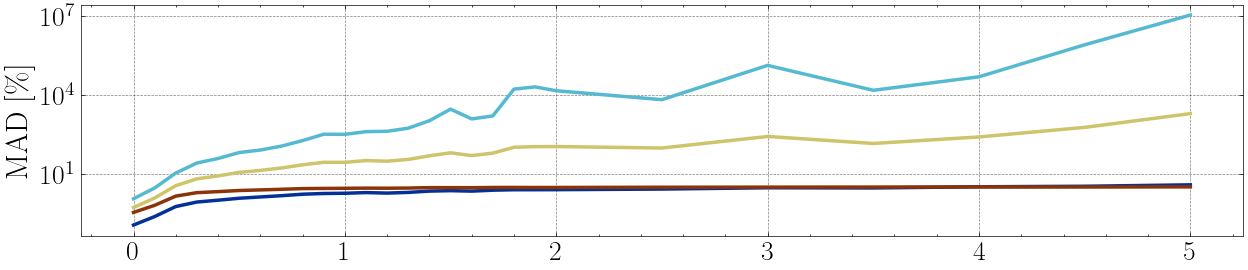

In [19]:
ens = 25
fig, axs = plt.subplots(1,1, figsize=(15,3))
for m,measure in enumerate(measures):
    axs.plot(df.columns.values,df.loc[(ens, measure)].values*100, label = names[m], lw = 2.5, color = colors[m])
    
axs.set_yscale("log")
axs.xaxis.set_tick_params(labelsize=ticksize)
axs.yaxis.set_tick_params(labelsize=ticksize)

# Only include legend for yacht plot
if experiment == "yacht":
    axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.23),
            fancybox=True, shadow=True, ncol=4, fontsize = legendsize)
    axs.set_xlabel(r"$\delta$", fontsize = labelsize)
axs.set_ylabel("MAD [\%]", fontsize = labelsize)

plt.savefig(f"../../plots/robustness_{experiment}.pdf", bbox_inches = "tight")